In [22]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

1. First I standardize the data and drop na values to clean, this is because dimensionality reduction methods can be sensitive to scale. Doing a PCA, I get a list of the eigenvectors of the covariance matrix, then I plot the number of prinicpal components against the cumulative explained variance ratio and I get the retained components by keeping only the vectors with explained variance or eigenvalues greater than 1. This means I keep 3 principal components using the Kaiser criterion. Using the plot, 3 eigenvalues accounts for about 66% of the variance which is most of it although under the conventional 80%. Plotting the data projected onto the first two principal components, which accounts for 55% of the variance, the data loses a lot of complexity and I printed the loadings dataframe to see how to interpret the eigenvectors of maximum variance. Flavinoids and total phenols has the highest correlation with the first principal component while alcohol and color intensity have the highest correlation with the second. Therefore, from the loadings dataframe, the first two principal components suggest the lower dimensional space captures a lot of variance based on alcohol, color intensity, flavinoids, and total phenols.   

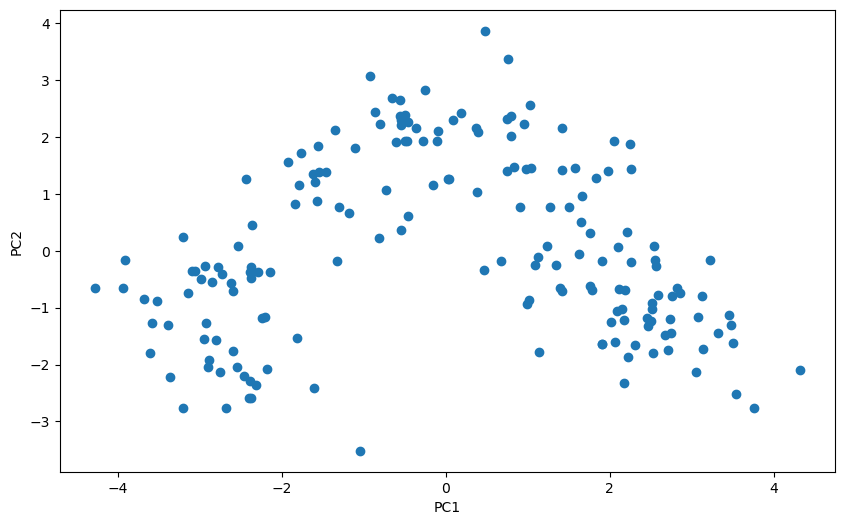

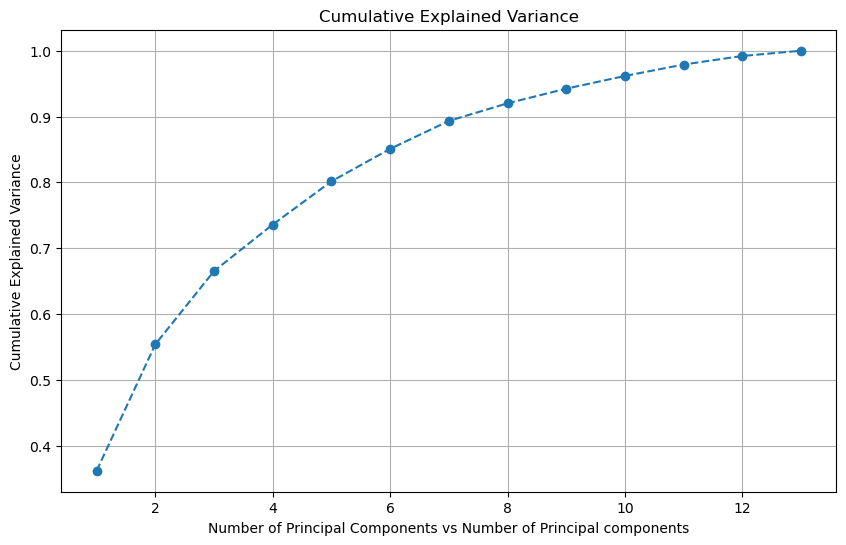

Number of retained components: 3
    Principal Component  Explained Variance Ratio  \
0                     1                  0.361988   
1                     2                  0.192075   
2                     3                  0.111236   
3                     4                  0.070690   
4                     5                  0.065633   
5                     6                  0.049358   
6                     7                  0.042387   
7                     8                  0.026807   
8                     9                  0.022222   
9                    10                  0.019300   
10                   11                  0.017368   
11                   12                  0.012982   
12                   13                  0.007952   

    Cumulative Explained Variance Ratio  
0                              0.361988  
1                              0.554063  
2                              0.665300  
3                              0.735990  
4             

In [94]:
data=pd.read_csv('/Users/marieqi/Downloads/wines.csv')
df=data.dropna()
pca=PCA()
scaler=StandardScaler()
X_std=scaler.fit_transform(df)
Xpca=pca.fit_transform(X_std)
df_pca=pd.DataFrame(data=Xpca[:,:2], columns=['PC1', 'PC2'])
ratio=pca.explained_variance_ratio_
cumvar=np.cumsum(ratio)
plt.figure(figsize=(10, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
components_table=pd.DataFrame({
    'Principal Component': range(1, pca.n_components_+1),
    'Explained Variance Ratio': ratio,
    'Cumulative Explained Variance Ratio': np.cumsum(pca.explained_variance_ratio_)
})
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumvar) + 1), cumvar, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components vs Number of Principal components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()
eigenvalues=pca.explained_variance_
retained_components=np.sum(eigenvalues>1)
print("Number of retained components:", retained_components)
print(components_table)
loadings=pca.components_
loadings_df=pd.DataFrame(loadings, columns=df.columns)
print(loadings_df)

2.To do a tSNE where I vary perplexities, I create an np array from 5 to 150 with increments of 5 units and I plot these perplexities against the resulting KL divergence, which measures differences in probability distributions. Then I plot the 2 dimensional embedded data with a perplexity of 20 and get a very different shape compared to the PCA, this is because tSNE depends on the hyperparameter of perplexity a lot and uses distances between points to compute the optimal embedding that minimizes conditional probability distribution divergence in the lower dimensional space compared to the higher one. Compare this to PCA which uses linear methods like covariance to get components, the information we capture in PCA is linear relationships. Using the plot of perplexities against KL divergence we see that a large perplexity minimizes the KL divergence, meaning the relative distances between points in the low dimensional space is best preserved when we select many nearest neighbors for each data point. 

0.458850622177124


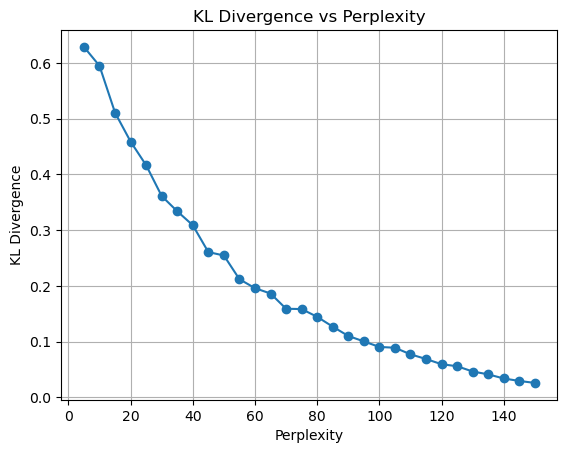

0.02610267885029316


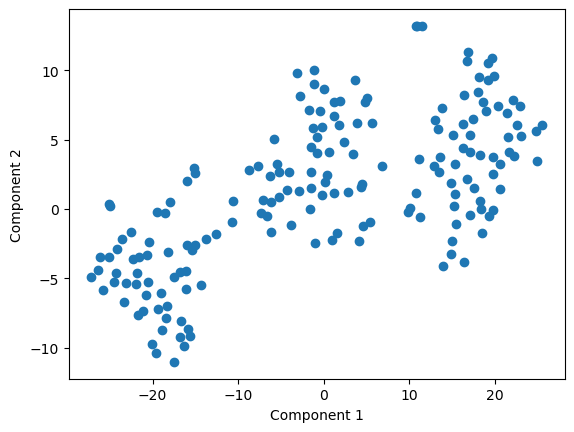

In [102]:
perplexities=np.arange(5,151,5)
kl_divergence=[]
for perplexity in perplexities:
    tsne=TSNE(perplexity=perplexity)
    X_embedded=tsne.fit_transform(X_std)
    kl_divergence.append(tsne.kl_divergence_)
    if perplexity==20:
        print(tsne.kl_divergence_)
plt.plot(perplexities,kl_divergence, marker='o')
plt.xlabel('Perplexity')
plt.ylabel('KL Divergence')
plt.title('KL Divergence vs Perplexity')
plt.grid(True)
plt.show()
print(min(kl_divergence))
X_embedded=TSNE(n_components=2, perplexity=20, n_jobs=-1).fit_transform(X_std)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

3. To prepare my data for MDS I flatten the values from my dataframe to a one dimensional array and reshape to a column vector before passing it to pairwise_distances, which will return the matrix of pairwise distances with diagonals 0. Then I run the mds on it with 2 components with precomputed dissimilarity since I directly passed the matrix as argument. Plotting the solution and getting the stress, I then normalize it by dividing by the sum of squared differences and I get a stress value of 6.983573178166307e-06 which is very close to optimal value of 0, this means the normalized sum of squared differences from the original and lower dimensional data is very small and the new embedding mostly retains the structure of the original data. tSNE with perplexity of 20 has a KL divergence of .4588 while a perplexity of 150 leads to a kl divergence of .02610. While KL divergence is not directly comparable to stress, overall MDS retains structure of the data better than tSNE does, but at higher runtime cost. 

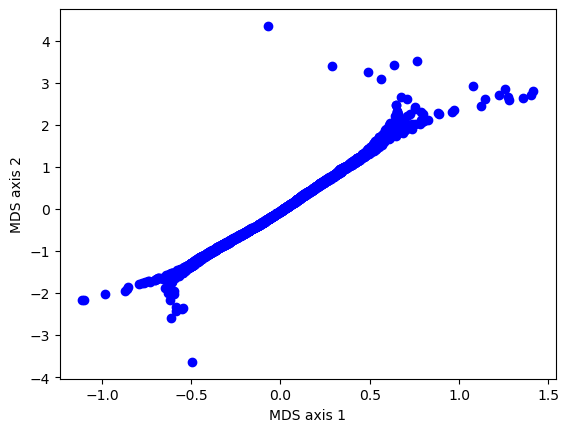

6.983573178166307e-06


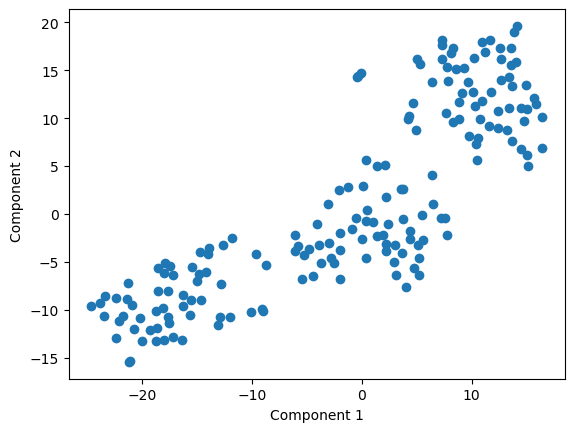

In [97]:
#code modified from lab8 
X_std=scaler.fit_transform(df)
dataVec=X_std.flatten() 
D=pairwise_distances(dataVec.reshape(-1, 1))
mds=MDS(n_components=2, dissimilarity='precomputed')
mdsSolution=mds.fit_transform(D)
plt.scatter(mdsSolution[:,0], mdsSolution[:,1], color='blue')
plt.xlabel('MDS axis 1')
plt.ylabel('MDS axis 2')
plt.show()
stress=mds.stress_/(np.sum(np.square(D)))
print(stress)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

4. First I define a cluster range with a minimum of 2 and using each cluster number as an argument for KMeans, I calculate silhouette score and plot it. Based on this the highest average silhouette score is obtained at 3 clusters, meaning the intercluster distance is minimized and intracluster distance is maximized with 3 clusters. Using this value I perform clustering on my reduced dimension data from PCA and I get a silhouette score of .6096 and sum of distances of each point to their centroid of 193. Doing the same thing on the tSNE embedding I get a similar silhouette score of .6098, but distance is much higher at 880.01587, which suggests clustering on the embedded data is much less tight than PCA, but the silhouette scores suggest this is balanced out by more distinctly spaced clusters. 

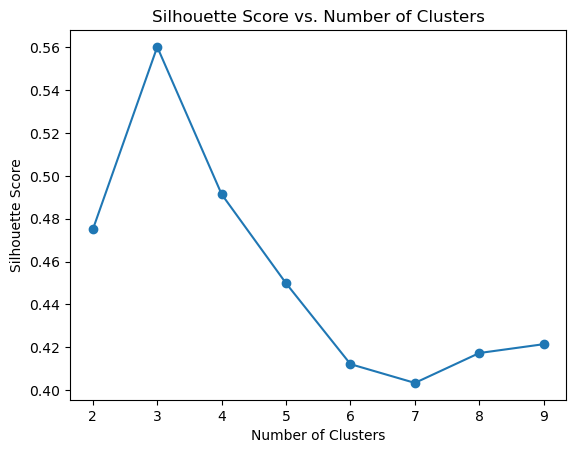

193.00803228232593


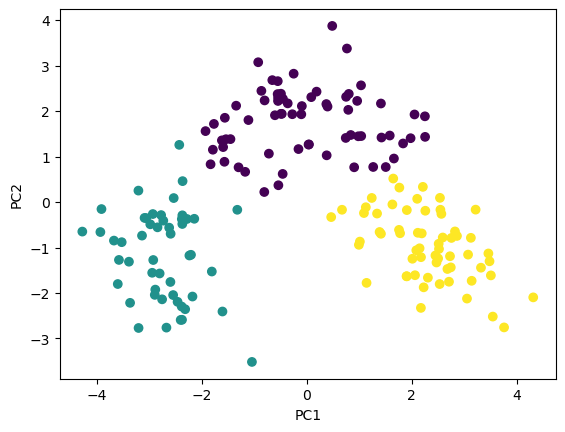

Silhouette Score  0.6096612729309193
880.01587


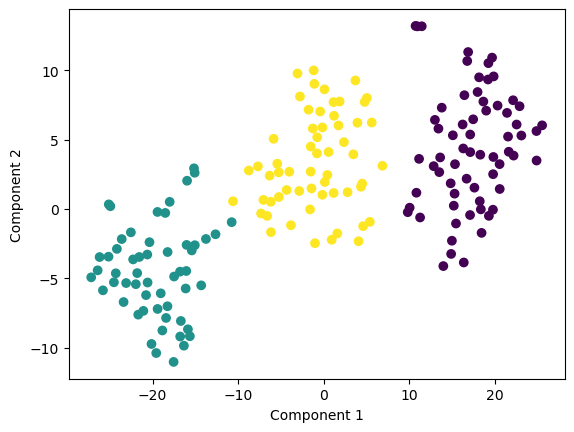

Silhouette Score  0.6098226


In [105]:
cluster_range=range(2, 10)
silhouette_scores=[]
kmeans=KMeans(n_clusters=2)
kmeans.fit(df_pca)
for n_clusters in cluster_range:
    kmeans=KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df_pca)
    labels=kmeans.labels_
    silhouette_avg=silhouette_score(df_pca, labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()
kmeans=KMeans(n_clusters=3)
kmeans.fit(df_pca)
centroids=kmeans.cluster_centers_
distances=pairwise_distances(df_pca, centroids)
total_distance=distances.min(axis=1).sum()
print(total_distance)
df_pca["Cluster"]=kmeans.labels_
fig = plt.figure()
plt.scatter(df_pca['PC1'], df_pca['PC2'],c=df_pca['Cluster'], cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

print('Silhouette Score ',silhouette_score(df_pca,kmeans.labels_))
kmeans=KMeans(n_clusters=3)
kmeans.fit(X_embedded)
centroids=kmeans.cluster_centers_
distances=pairwise_distances(X_embedded, centroids)
total_distance=distances.min(axis=1).sum()
print(total_distance)
X_embedded_with_labels=np.column_stack((X_embedded, kmeans.labels_))
fig=plt.figure()
plt.scatter(X_embedded_with_labels[:, 0], X_embedded_with_labels[:, 1], c=X_embedded_with_labels[:, 2], cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
print('Silhouette Score ',silhouette_score(X_embedded,kmeans.labels_))


5. First I tune my hyperparameters with an array of epsilons and minimum samples per cluster. I do this by fixing the other hyperparameter and iterating through the array and I used silhouette score as the metric to see which hyperparameter would perform the best on the tSNE embedding. Plotting the silhouette scores against each hyperparameter I get an optimal epsilon of 3 and optimal min_samples of 4, meaning there should be at least 4 samples in a neighborhood of the centroid to be considered a dense region and any points within 3 standard deviations of each other will be in the same neighborhood, and for every point in the same dense region, the points within the epsilon neighborhood will be in the same cluster. These are the values that minimize the distance within the cluster and the distance of each cluster to each other, Using these for DBSCAN I get three clusters with a silhouette score of 0.5569419, which is lower than kmeans, which suggests that using kmeans is better most likely because we do not find many noise points and clusters are mostly uniform.

extra credit: Based on the k means clustering and DBScan which both resulted in 3 clusters, there are 3 different types of wines and based on the loadings matrix of the PCA, they differ mostly based on alcohol, color intensity, flavinoids, and total phenols. Based on the correlation matrix alcohol content contribute to greater color intensity, while flavinoids and total phenols contribute to hue, which is because flavinoids and phenols are usually found in higher concentrations in red grapes. Therefore the types may be white, red, and rose. 

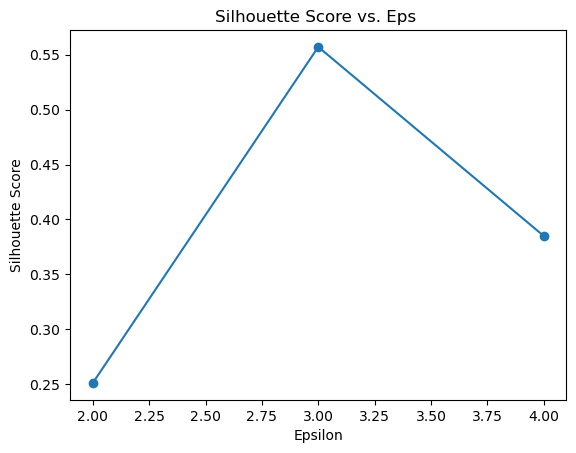

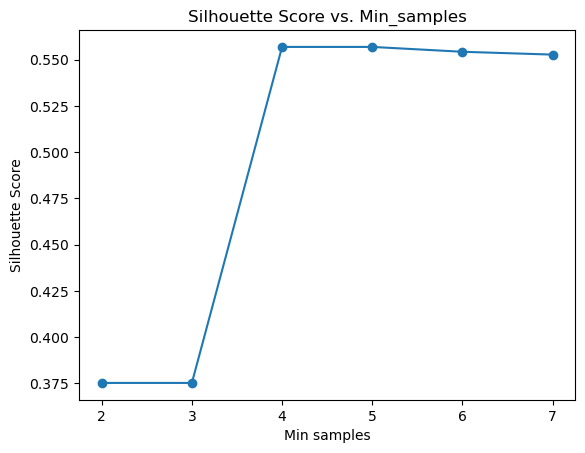

Best Silhouette Score:(0.5569419, 0.5569419)(eps=3,min_samples=4)


In [81]:
eps_values=[2,3,4]  
min_samples_values=[2,3,4,5,6,7] 
best_score1=-1
best_score2=-1
best_eps=None
best_min_samples=None
silhouettes1=[]
silhouettes2=[]

for eps in eps_values:
    dbscan=DBSCAN(eps=eps,min_samples=4)
    labels=dbscan.fit_predict(X_embedded)
    if len(set(labels))>1:
        silhouette=silhouette_score(X_embedded,labels)
        silhouettes1.append(silhouette)
        if silhouette>best_score1:
            best_score1=silhouette
            best_eps=eps
for min_samples in min_samples_values:
    dbscan=DBSCAN(eps=3,min_samples=min_samples)
    labels=dbscan.fit_predict(X_embedded)
    if len(set(labels))>1: 
        silhouette=silhouette_score(X_embedded, labels)
        silhouettes2.append(silhouette)
        if silhouette>best_score2:
            best_score2=silhouette
            best_min_samples=min_samples
plt.plot(eps_values,silhouettes1, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Eps ')
plt.show()
plt.plot(min_samples_values,silhouettes2, marker='o')
plt.xlabel('Min samples')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Min_samples')
plt.show()
print(f'Best Silhouette Score:{best_score1, best_score2}(eps={best_eps},min_samples={best_min_samples})')

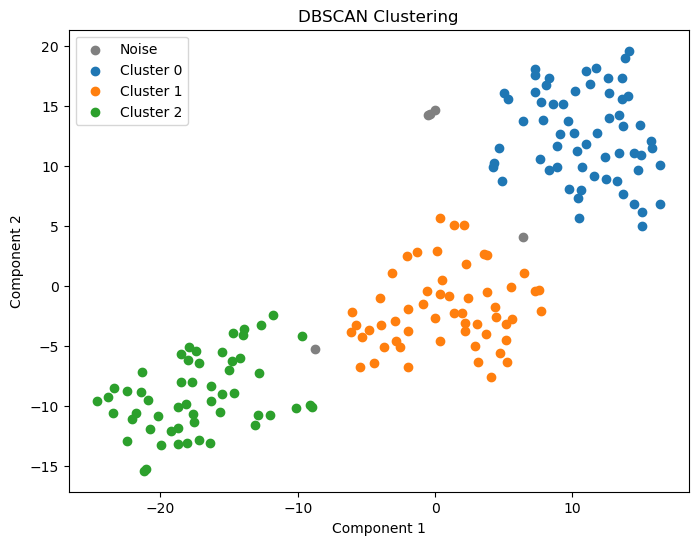

In [84]:

dbscan=DBSCAN(eps=3,min_samples=4)
dbscan.fit(X_embedded)
labels=dbscan.labels_
plt.figure(figsize=(8, 6))
unique_labels=np.unique(labels)
for label in unique_labels:
    if label==-1:
        plt.scatter(X_embedded[labels==label][:, 0], X_embedded[labels==label][:, 1],color='gray',label='Noise')
    else:
        plt.scatter(X_embedded[labels==label][:, 0], X_embedded[labels==label][:, 1],label=f'Cluster {label}')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

In [108]:
print(df.corr())

                  Alcohol  Malic_Acid       Ash  Ash_Alkalinity  Magnesium  \
Alcohol          1.000000    0.094397  0.211545       -0.310235   0.270798   
Malic_Acid       0.094397    1.000000  0.164045        0.288500  -0.054575   
Ash              0.211545    0.164045  1.000000        0.443367   0.286587   
Ash_Alkalinity  -0.310235    0.288500  0.443367        1.000000  -0.083333   
Magnesium        0.270798   -0.054575  0.286587       -0.083333   1.000000   
Total_Phenols    0.289101   -0.335167  0.128980       -0.321113   0.214401   
Flavonoids       0.236815   -0.411007  0.115077       -0.351370   0.195784   
Stilbenes       -0.155929    0.292977  0.186230        0.361922  -0.256294   
Proanthocyanins  0.136698   -0.220746  0.009652       -0.197327   0.236441   
Color_Intensity  0.546364    0.248985  0.258887        0.018732   0.199950   
Hue             -0.071747   -0.561296 -0.074667       -0.273955   0.055398   
OD280            0.072343   -0.368710  0.003911       -0.276769 